<h1 style="text-align: center; color: #8D7334; font-weight: bold; font-style: italic; text-decoration: underline; "> Forecasting Stock prices with Recurrent Neural Networks (RNN)</h1>

<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  University of Colorado Boulder </h2>
<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  Master of Data Science </h2>
<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  DTSA 5511 Introduction to Deep Learning -- Week 6 -- Final Project -- </h2>
<br>
<br>
<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Introduction and Key Objectives:</h3>

The main objective of this project is to use Long Sort Term Memory (LSTM) RNN to predict future closing prices of constituents stocks in the S&P500. 
I will use the Tensorflow Keras packages which offer a tunable LSTM framework.
The LSTM is able to capture and retain historical patterns and make suitable models to fit sequential data.
I use a multi-stock, multi-index, and other securities time series to forecast future closing prices, specifically predicting the next 5-day closing prices of a target stock (I use AAPL as a default) by leveraging Open High Low Close Volume (OHLC) data.

The data set consists of individual .csv files with time series of Open Low High Close prices and Volume traded (OLHCV) on 500 S&P500 stocks, 2,3,5,10,30-year US Treasury bond yields, world stock indices such as S&P500, Nasdaq100, Nikkei, DAX, Hang Seng, STI, FTSE, and commodities such Crude Oil and Gold. The idea behind is that the appeal of given security at a certain price to an investor is a function of all other investment options an investor would have. For the purpose of this paper, I take Aple Inc (ticker AAPL) as a target stock to predict. However, the model can make a prediction on any security as long as we have a time series on it.
I downloaded the initial set of .csv files in February 2025 at the time of writing my final project on DTSA 5509, Applying Regression and Ensemble Techniques to Predict Stock Prices. I I updated the datset now through 2025-08-14.

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Load packages: </h3>


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import random
import time

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
from numpy.linalg import norm

random.seed(2025)
np.random.seed(2025)
tf.random.set_seed(2025)



# Download and update time series through Yahoo Finance:
import yfinance as yf
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
        pass


/home/lrt/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/lrt/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-08-30 16:47:50.904353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756586870.987554     427 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756586871.0097

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Description of the Dataset, Data Cleaning, Preprocessing, and EDA: </h3>
The data set consists of individual .csv files with time series of Open Low High Close prices and Volume traded (OLHCV) on 500 S&P500 stocks, 2,3,5,10,30-year US Treasury bond yields, world stock indices such as S&P500, Nasdaq100, Nikkei, DAX, Hang Seng, STI, FTSE, and commodities such Crude Oil and Gold, downloaded and/or updated through Yahoo Finance. I downloaded the initial set of .csv files in February 2025 at the time of writing the final project on DTSA 5509 (Applying Regression and 
Ensemble Techniques to Predict Stock Prices) and I update the download now through 2025-08-14

The complete list of S&P500 constituents is not available through YF, but is available through https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies.

This is the download and update code, and is deliberately independent from the main RNN/LSTM code, since it runs only once at the beginning of the project. The code downloads the entire data series from YF if there is no file in the data directory; or it updates it if there is a file already there.

With 500 stocks, each providing 5 features, in steps of 5 trading sessions, the feature space becomes 500x5x5=12,500.




In [2]:
# This function builds a path to the data folder where we save the data files.
def buildFilePath( tickerSymbol ):
        cwd = os.getcwd()
        pathToData = cwd +"/data/"
        fileName = pathToData + tickerSymbol + ".csv"
        return fileName

# Download a list of 500 tickers from wikipedia:
def list_wikipedia_sp500() -> pd.DataFrame:
        #Ref: https://stackoverflow.com/a/75845569/
        url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
        sp500ListWiki = pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]
        sp500ListWiki.reset_index(inplace=True)
        fileName = buildFilePath( "sp500ListWiki" )
        sp500ListWiki.to_csv(fileName, header=True, index=False)
        return sp500ListWiki 

session = CachedLimiterSession(
                    # max 2 requests per 5 seconds
                    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),
                    bucket_class=MemoryQueueBucket,
                    backend=SQLiteCache("yfinance.cache") )

notAvailableYf = []
def getTickerYf( tickerSymbol ):
        #Create a Ticker object
        print("\nLine 53: \nTicker:", tickerSymbol, "connect to YF.")
        ticker = yf.Ticker(tickerSymbol, session = session )
        #print("\nLine 57: \nticker object:", type(ticker), ticker.info)
        # The scraped response will be stored in the cache
        ticker.actions
        # Check if the .csv file exists. If it does, update it. Otherwise period=max.
        fileName = buildFilePath( tickerSymbol )
        if os.path.isfile(fileName): # if true, file exits. It means I downloaded before and can update now.
                print("\nLine 60: \nTicker:", tickerSymbol, "file exists. Download update.")
                # Get the start date from the last row of the existing file.
                tempSymbolDF = pd.read_csv(fileName)
                nRowTempDF = tempSymbolDF.shape[0] # number of rows in the DF.
                # https://www.geeksforgeeks.org/python-convert-string-to-datetime-and-vice-versa/
                #format = '%Y-%m-%d'
                #startDate = datetime.datetime.strptime(tempSymbolDF.Date[nRowTempDF-1], format).date()
                startDate = tempSymbolDF.Date[nRowTempDF-1]
                #startDate = datetime.datetime(2024,12,12) # This is the last date on the existing file
                #endDate = datetime.datetime.strftime(datetime.datetime.now() - datetime.timedelta(1), "%Y-%m-%d") # date time as string
                endDate = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d") # date time as string
                histoData = ticker.history(start=startDate, end=endDate).iloc[1:,0:6]
                print("\nLine 72: \nstartDate:", startDate, "endDate=", endDate, histoData.tail())
                
        else: #the file does not exist. Download max range.
                print("\nLine 75: \nTicker:", tickerSymbol, "file does not exist. Download max.")
                histoData = ticker.history(period="max")
        
        #Fetch historical market data:
        if( histoData.shape[0] == 0): # no rows, no data.
                print("\nLine 68: \nTicker:", tickerSymbol, "not available.")
                notAvailableYf.append(tickerSymbol) 
        else:
                # Reset index and treat Date column as a date column.
                histoData.reset_index(inplace=True)
                histoData["Date"] = histoData["Date"].dt.strftime('%Y-%m-%d')
                                
                if os.path.isfile(fileName): #If file exists, add the update to the end of DF.
                        tempSymbolDF = tempSymbolDF._append(histoData.iloc[:histoData.shape[0]+2, ], ignore_index= True)
                        tempSymbolDF.to_csv(fileName,header=True, index=False)
                        print("\nLine 85: \nTicker:", tickerSymbol, "\n Save updated DF.")
                else:# file does not exist.
                        print("\nLine 87: \nTicker:", tickerSymbol, "\n Save max period.")
                        histoData.iloc[:histoData.shape[0], ].to_csv(fileName, header=True, index=False)
        return

# Add in the for loop:
#time.sleep(seconds) 

#============================================
# Download Indices: SP500, Nasdaq100, DJIA time series only once:
marketIndices = ["^GSPC", "^DJI", "^IXIC", "^GDAXI", "^FTSE", "^FCHI", "^N225", "^HSI", "^STI"] 
bondIndices = ["^TYX", "^TNX","^FVX","^IRX"]
cmdtyIndices= ["GLD","CL=F","DX-Y.NYB"]
#==============================================
def getTickerWraperYf( tickerList ):
        for ticker in tickerList:
                getTickerYf(ticker)
        return
# Download once:
#getTickerWraperYf(marketIndices)
#getTickerWraperYf(cmdtyIndices)


#===============================================
# Load the list of 500 tickers, just once.
sp500Stocks = list(pd.read_csv("sp500ListWiki.csv")["Symbol"])
nTickers = len(sp500Stocks)
print("\nLine 84: sp500Stocks:\n", sp500Stocks, "\nTickers=", nTickers )

# Main loop: Retrieve data from yf one time.
t0 = time.time()
# yahoo finance syntax: ["BF-B", "BRK-B"]
# wikipedia list syntax: ["BF.B", "BRK.B"]
# Dictionary to map from wikipedia to yf. This is the same syntax used to save the files:
syntaxDict = { "BF.B":"BF-B", "BRK.B":"BRK-B"}
yfSyntaxRejected = ["BF-B", "BRK-B"] #BF.B, BRK.B
def getAllTickers( tickerList ):
        for i in range( len(tickerList)):
                tickerSymbolTemp = tickerList[i]
                if (tickerSymbolTemp == "BF.B"):
                        tickerSymbolTemp = "BF-B"
                        continue
                if (tickerSymbolTemp == "BRK.B"):
                        tickerSymbolTemp = "BRK-B"
                        continue
                #tickerSymbolTemp =  testSample[i]
                getTickerYf( tickerSymbolTemp )
        return
t1 = time.time()
# Test one stock.
#===================
#tickerSymbol = "AAPL"
#getTickerYf(tickerSymbol)
#print("\nLine 145: tickerSymbol=", tickerSymbol )

# Download once:
#================
#getTickerWraperYf(marketIndices)
#getTickerWraperYf(cmdtyIndices)
#getAllTickers( sp500Stocks )
#getAllTickers(yfSyntaxRejected)
#print("\nLine 141: total time=", (t1-t0) , "\nnotAvailableYf=", notAvailableYf )
#===========================================================================================




Line 84: sp500Stocks:
 ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR',

Let's look at the typical download of a data series:

In [3]:
tickerSymbol = "AAPL"
fileName = buildFilePath(tickerSymbol )
sampleSymbolDF = pd.read_csv(fileName)
sampleSymbolDF.info()

print("\n First 6 lines of data series for ", tickerSymbol , "\n", sampleSymbolDF.iloc[:,0:6].head())

print("\n Most recent 6 lines of data series for ", tickerSymbol , "\n", sampleSymbolDF.iloc[:,0:6].tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11259 entries, 0 to 11258
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          11259 non-null  object 
 1   Open          11259 non-null  float64
 2   High          11259 non-null  float64
 3   Low           11259 non-null  float64
 4   Close         11259 non-null  float64
 5   Volume        11259 non-null  object 
 6   Dividends     11259 non-null  float64
 7   Stock Splits  11138 non-null  float64
dtypes: float64(6), object(2)
memory usage: 703.8+ KB

 First 6 lines of data series for  AAPL 
          Date   Open   High    Low  Close       Volume
0  1980-12-12  0.099  0.099  0.099  0.099  469,033,600
1  1980-12-15  0.094  0.094  0.094  0.094  175,884,800
2  1980-12-16  0.087  0.087  0.087  0.087  105,728,000
3  1980-12-17  0.089  0.089  0.089  0.089   86,441,600
4  1980-12-18  0.091  0.092  0.091  0.091   73,449,600

 Most recent 6 lines of data serie

The individual .csv files contain a time series of Open High Low Close prices, and Volume. Volume is incomplete or missing in many of the downloads. In those instances, volume is filled with a value of zero.

The data is generally clean and complete. In a few instance (Berkshire tickers A and B for example) the wiki ticker does not match the one at YF and some adjustments are made for that in the code. About a dozen stocks in the S&P have short history of trading (less than 1,000 sessions, about 4 years), and I filter those out. Lastly, about 10 tickers are unable to update through 2025-08-14. This securities may have stopped trading, or simply can not update through this code from YF with a reasonable effort. It is only a handful of them, and I filter them out of the data set as well. This cleaning is done through the code, it is done once at the beginning of the process, and I provide print outs along the process to highlight what is being excluded.

The data is aligned through dates, and scaled. All stocks in the sample eventually converge to the same number of trading sessions (set to be )> 1,000). 

In [22]:
# =========================================================
# DATA LOADING AND ALIGNMENT THROUGH DATE SEQUENCE
# =========================================================
def loadAllStocksData():
        #Load OHLCV data of all stocks as dict of DataFrames.
        # This is the list of 12 stocks outdated.
        #outdatedStocks=[]
        shortSequence = []
        #shortSequence =  ['AMTM', 'CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV', 'SW', 'VLTO']
        outdatedStocks = ['AMTM', 'ANSS', 'BF-B', 'BRK-B', 'BWA', 'CE', 'DFS', 'FMC', 'HES', 'JNPR', 'QRVO', 'TFX']
        
        stockDataDict = {}
        for filename in os.listdir(dataFolder):
                #print("\nLine 40: filename=", filename)
                if filename.endswith(".csv"):
                        ticker = filename[:-4].upper()
                        df = pd.read_csv(os.path.join(dataFolder, filename))
        
                        # If the series is too short, do not include it.
                        if len(df) > minSeq:
                                # Identify outdated stocks:
                                #===========================
                                # Run this code once. There is only 10 or so stocks which fail to update. Save the fix list for future runs.
                                #if pd.to_datetime(df['Date'].max()) not in [ pd.to_datetime('2025-08-14'), pd.to_datetime('2025-08-15')]:
                                #        outdatedStocks.append(ticker)
                                #        print("\nLine 102: ticker=", ticker, "datemax=", df['Date'].max())
                                #        continue
                                if ticker not in outdatedStocks:
                                        expectedColsBase = ['Date', 'Open', 'High', 'Low', 'Close'] # Volume sometimes not there.
                                        if 'Volume' in df.columns:
                                                volumeNonZeroRatio = (df['Volume'] != 0).sum() / len(df)
                                                if volumeNonZeroRatio > 0.5: # more than half the series has volume data.
                                                        expectedCols = expectedColsBase + ['Volume']
                                                else:
                                                        expectedCols = expectedColsBase
                                                        print("\nLine 115: ticker=", ticker, "Volume data present less than 1/2 the time. Volume excluded in this ticker.")
                                        else:
                                                expectedCols = expectedColsBase
        
                                        if all(col in df.columns for col in expectedCols):
                                                df = df[expectedCols]
                                                df['Date'] = pd.to_datetime(df['Date'])
                                                df.sort_values(by='Date', inplace=True)
                                                df.reset_index(drop=True, inplace=True)
                                                
                                                if 'Volume' in df.columns:
                                                        df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce').fillna(0)
                                                        #df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce').ffill(0)
                                                else:
                                                        df['Volume'] = 0 #add a zero filled Volume column if missing
        
                                                stockDataDict[ticker] = df
                                        else:
                                                print("\nLine 132: ticker=", ticker, "series incomplete. This ticker will not be part of the series.")
                                else:
                                        print("\nLine 134: ticker=", ticker, "datemax=", df['Date'].max())
                        else:
                                shortSequence.append(ticker)
        
        print("\nLine 138: outdatedStocks=", outdatedStocks, len(outdatedStocks), "These stocks will not be included.")
        print("\nLine 139: short sequence=", shortSequence, len(shortSequence), "These stocks do not have enough history.")
        return stockDataDict


def alignStocksOnCommonDate(stockDataDict):
        #Align all stocks to common Dates with forward-filling gaps.
        maxStartDate = max(df['Date'].min() for df in stockDataDict.values())
        minEndDate = min(df['Date'].max() for df in stockDataDict.values())
        print("\nLine 111: date range:\n", maxStartDate, minEndDate)
        
        commonDates = pd.date_range(start=maxStartDate, end=minEndDate, freq='B')
        
        alignedData = {}
        targetDate = pd.to_datetime('2025-08-14')
        for ticker, df in stockDataDict.items():
                df = df.set_index('Date').reindex(commonDates)
                df.fillna(method='ffill', inplace=True)
                df.fillna(0, inplace=True)
                #df.ffill(0, inplace=True) # error message when running script
                alignedData[ticker] = df
                lastDate = df.dropna(how='all').index[-1] #last date with data
                #print("\nLine 131: lastDate:", lastDate, ticker)
                if lastDate != targetDate:
                        print("\nLine 131: Stock not updated:", ticker)
                        break
        
        return alignedData, commonDates


# =========================================================
# DATASET CREATION
# =========================================================
def createDataset(alignedData, commonDates):
        #Create input feature sequences X and multi-day targets y arrays.
        #X shape: (samples, sequenceLength, numStocks * featuresPerStock)
        #y shape: (samples, forecastHorizon) for multi-day ahead Close prices of target stock
        
        numSamples = int(len(commonDates) - sequenceLength - forecastHorizon + 1)
        print("\nLine 87: numSamples=", numSamples)
        
        sampleStock = next(iter(alignedData.values()))
        featuresPerStock = sampleStock.shape[1]
        numStocks = len(alignedData)
        
        X = np.zeros((numSamples, sequenceLength, numStocks * featuresPerStock), dtype=np.float32)
        y = np.zeros((numSamples, forecastHorizon), dtype=np.float32)
        print("\nLine 92: X SHAPE=", X.shape)
        print("\nLine 93: y SHAPE=", y.shape)
        
        sortedTickers = sorted(alignedData.keys())
        allStocksArr = np.hstack([alignedData[t].values for t in sortedTickers])
        
        tgtIdx = sortedTickers.index(targetStock)
        CloseColIndex = tgtIdx * featuresPerStock + 3 #Close price column index for target stock
        
        for i in range(numSamples):
                X[i] = allStocksArr[i:i + sequenceLength]
                y[i] = allStocksArr[i + sequenceLength : i + sequenceLength + forecastHorizon, CloseColIndex]
        
        return X, y


# =========================================================
# SCALING
# =========================================================
def scaleData(XTrain, XValTest):
        #Scale features separately using train set statistics.
        scaler = MinMaxScaler()
        
        nsamples, ntimesteps, nfeatures = XTrain.shape
        XTrainFlat = XTrain.reshape(-1, nfeatures)
        scaler.fit(XTrainFlat)
        
        XTrainScaled = scaler.transform(XTrainFlat).reshape(nsamples, ntimesteps, nfeatures)
        
        nsamplesVal = XValTest.shape[0]
        XValFlat = XValTest.reshape(-1, nfeatures)
        XValTestScaled = scaler.transform(XValFlat).reshape(nsamplesVal, ntimesteps, nfeatures)
        
        return XTrainScaled, XValTestScaled, scaler


def scaleTargets(yTrain, yValTest):
        #Scale targets (multi-output) using train set.
        scaler = MinMaxScaler()
        scaler.fit(yTrain) #yTrain shape: (samples, forecastHorizon)
        
        yTrainScaled = scaler.transform(yTrain)
        yValTestScaled = scaler.transform(yValTest)
        
        return yTrainScaled, yValTestScaled, scaler



<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> 
 Model architecture: </h3>
Generally speaking, Long-Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) model suitable for learning sequential data. LSTMs solve the vanishing/exploding gradient challenges that traditional RNNs suffer from. 

An LSTM contains memory cells and gates (input, output, and forget gates). These gates allow the network to regulate and selectively store, retrieve, or forget information over long periods. This architecture helps LSTMs remember relevant information for much longer than traditional RNNs, which typically only capture short-term patterns. One of the many applications of LSTMs is in financial forecasting from time series sequential data.

The LSTM presented below has a Bidirectional LSTM captures past and future context within the input window, followed by a unidirectional LSTM, a dropout layer to prevent overfitting, a fully connected Dense layer, and the final output layer which directly forecasts multiple (5) steps ahead.

Keras provides a straightforward API for creating LSTM models. 

Training takes several hours to complete in my CPU, and takes more than 80% of the available RAM (16gb in my system). The last successful training took 23 hours to complete after the process was interrumpted several times by system shutdowns. (I am now waiting for the delivery of 2 memory sticks to double RAM capacity).



In [32]:
# =========================================================
# MODEL BUILDING 
# =========================================================

def buildLstmModel(hp):
        #Build a simple LSTM model and return forecast of 5 sessions forward.
        #Hyperparameters: lstmUnits, dropoutRate, learningRate.
        lstmUnits = hp.Int('lstmUnits', min_value=lstmUnitsMin, max_value=lstmUnitsMax, step=lstmUnitsStep)
        dropoutRate = hp.Float('dropoutRate', doMin, doMax, step=doStep)
        learningRate = hp.Float('learningRate', lrMin, lrMax, sampling='log')
        l2Reg = hp.Float('l2Reg', l2RegMin, l2RegMax, step=l2RegStep) #Add L2 reg tunable parameter
        
        global numStocks, featuresPerStock
        inputs = Input(shape=(sequenceLength, numStocks * featuresPerStock))
        # Initially one lSTM layer. Evolved to bidirectional stacked layers.
        #x = LSTM(lstmUnits, return_sequences=False)(inputs)
        x = Bidirectional(LSTM(lstmUnits, return_sequences=True, kernel_regularizer=regularizers.l2(l2Reg)))(inputs)
        x = LSTM(lstmUnits//2, return_sequences=False, kernel_regularizer=regularizers.l2(l2Reg))(x)
        
        if dropoutRate > 0.0:
                x = Dropout(dropoutRate)(x)
        x = Dense(64, activation="relu")(x)
        outputs = Dense(forecastHorizon)(x) #outputs forecast for multiple days
        
        model = Model(inputs=inputs, outputs=outputs)
        optimizer = Adam(learning_rate=learningRate)
        model.compile(optimizer=optimizer, loss=bestLoss, metrics=[bestMetrics])
        
        return model


# =========================================================
# VISUALIZATION FUNCTION
# =========================================================

def plotResults(Dates, yTrueTrain, yPredTrain, yTrueVal, yPredVal, yTestTrue, yTestPred):
        plt.figure(figsize=(16, 8))
        
        dayToPlot = 0 #Plot first forecast day.
        
        plt.plot(Dates[:len(yTrueTrain)], yTrueTrain[:, dayToPlot], label="Train Real Close")
        plt.plot(Dates[:len(yPredTrain)], yPredTrain[:, dayToPlot], '--', label="Train Predicted Close")
        
        plt.plot(Dates[len(yTrueTrain):len(yTrueTrain) + len(yTrueVal)], yTrueVal[:, dayToPlot], label="Validation Real Close")
        plt.plot(Dates[len(yPredTrain):len(yPredTrain) + len(yPredVal)], yPredVal[:, dayToPlot], '--', label="Validation Predicted Close")
        
        plt.plot(Dates[-len(yTestTrue):], yTestTrue[:, dayToPlot], label="Test Real Close")
        plt.plot(Dates[-len(yTestPred):], yTestPred[:, dayToPlot], '--', label="Test Predicted Close")
        
        plt.title(f"{targetStock} Close Price Day {dayToPlot + 1}: True vs Predicted")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.savefig(targetStock+"Rev1.png")
        plt.show()
        return


# =========================================================
# SAVE AND LOAD MODEL FUNCTIONS
# =========================================================
modelSavePath = "trainedLSTMModelRev1.keras"

def saveModel(model, path=modelSavePath):
        model.save(path)
        print("\nLine 301: Model saved to", path)
        return

def loadTrainedModel(path=modelSavePath):
        if os.path.exists(path):
                model = load_model(path)
                print("\nLine 307: Model loaded from", path)
                return model
        else:
                print("\nLine 310:No saved model found at", path)
                return None



<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Model Parameters and Hyperparameters Tuning: </h3>
The model incorporates a drop out rate, learning rate, number of LSTM units and L2 regularization rate in ranges to be tuned by the KerasTunde RandomSearch process. 


Training includes an Optimizer (Adam with tuned learning rate), loss (Mean Absolute Percentage Error (MAPE) or RMSE), EarlyStopping (on validation RMSE or MPAE with a patience paremeter), Epochs (tested in a range 5-1000), and a Batch Size (up to 32).

After fitting and compiling the model, the trained model is saved and the best hyperparameters --those leading to the lowest RMSE / MAPE on the validation sample-- are reported.

The model trains on a training sample, it searches for best hyperparameters in a validation sample, and provides and estimate of the error of the model through a test sample. Lastly, the model forecasts the closing of AAPL 5 days ahead (one forecast for each day) and estimates the error of that forecast (based on the results obtained with the test sample). Three samples are used to ensure that the model faces unseen data every time a new measure is derived.

I looked at several combinations of loss and validation errors. The measure that makes more sense in this case is MAPE since it is directly related to the values (closing prices) in the original scale of the data. MAPE is less friendly than RMSE as a loss function. However, I did not have any problems applying it to this case. I eventually decided in favor of keeping RMSE for training and MAPE for validation.

In [39]:
# =========================================================
# PARAMETERS
# =========================================================
mainDir = os.getcwd()
#print("\nLine45:mainDir=", mainDir)
dataFolder = os.path.join(mainDir, "data") #Folder with your 500 stock CSVs
#print("\nLine47: dataFolder=", dataFolder)

targetStock = "AAPL" # Target stock ticker
sequenceLength = 5 # Input sequence length
forecastHorizon = 5 # Days ahead forecast horizon
featuresPerStock = 4 # Features per stock (OHLC+V)
modelSavePath = "trainedLSTMModelRev1.keras" #File path to save best model

# epoch = 200; early stop = 100; max trials = 400; early stop x max trials = 400 x 100 = 40000. This takes days to run.
# Try to run overnight 8 hours.
epochMax = 15# 150, 300, 1000
earlyStopPatience = 10#, 100. Patience now 40, can go down to 10/15.

#Tuner parameter optimization:
maxTunerTrials = 5 # 250, 400. Trials gives the number of hyperparameters combinations. More is better.
bestObjective='val_mean_absolute_percentage_error' # tuner
bestMonitor='val_mean_absolute_percentage_error' # early stop

doMin = 0.0 # set to 0.1
doMax = 0.2
doStep = 0.05

lrMin = 5e-7 #1e-5, 5e-8
lrMax = 1e-5 #2e-3 1e-7 # set to 5e-6

lstmUnitsMin = 1400 # 64 may be too small. Bump to 400+
lstmUnitsMax = 2048 # set to 1600
lstmUnitsStep = 32

minSeq = 1000

# Model compilation parameters:
bestLoss= "mse" #"mape"
bestMetrics = tf.keras.metrics.MeanAbsolutePercentageError()

bsMax = 32

l2RegMin = 0.0
l2RegMax = 0.005 # set to 0.002
l2RegStep = 0.001

trainRatio = 0.7
valRatio = 0.15




<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Driver Code: </h3>
This piece of the code integrates all the elements of model and produces the final output.


Trial 5 Complete [00h 12m 25s]
val_mean_absolute_percentage_error: 28.22052764892578

Best val_mean_absolute_percentage_error So Far: 26.62744140625
Total elapsed time: 01h 14m 08s

Line 414: Get best model

Line 417: Fine-tune best model and get training history
Epoch 1/15


/home/lrt/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


26/26 - 81s - 3s/step - loss: 10.8101 - mean_absolute_percentage_error: 113572.1641 - val_loss: 10.9174 - val_mean_absolute_percentage_error: 27.2747
Epoch 2/15
26/26 - 77s - 3s/step - loss: 10.7625 - mean_absolute_percentage_error: 103374.1484 - val_loss: 10.8943 - val_mean_absolute_percentage_error: 28.9536
Epoch 3/15
26/26 - 75s - 3s/step - loss: 10.7154 - mean_absolute_percentage_error: 79231.0625 - val_loss: 10.8567 - val_mean_absolute_percentage_error: 29.4554
Epoch 4/15
26/26 - 75s - 3s/step - loss: 10.6692 - mean_absolute_percentage_error: 58716.9219 - val_loss: 10.8290 - val_mean_absolute_percentage_error: 30.6579
Epoch 5/15
26/26 - 75s - 3s/step - loss: 10.6225 - mean_absolute_percentage_error: 99535.2344 - val_loss: 10.8024 - val_mean_absolute_percentage_error: 31.9723
Epoch 6/15
26/26 - 75s - 3s/step - loss: 10.5765 - mean_absolute_percentage_error: 73788.3359 - val_loss: 10.7592 - val_mean_absolute_percentage_error: 32.1150
Epoch 7/15
26/26 - 74s - 3s/step - loss: 10.5307 

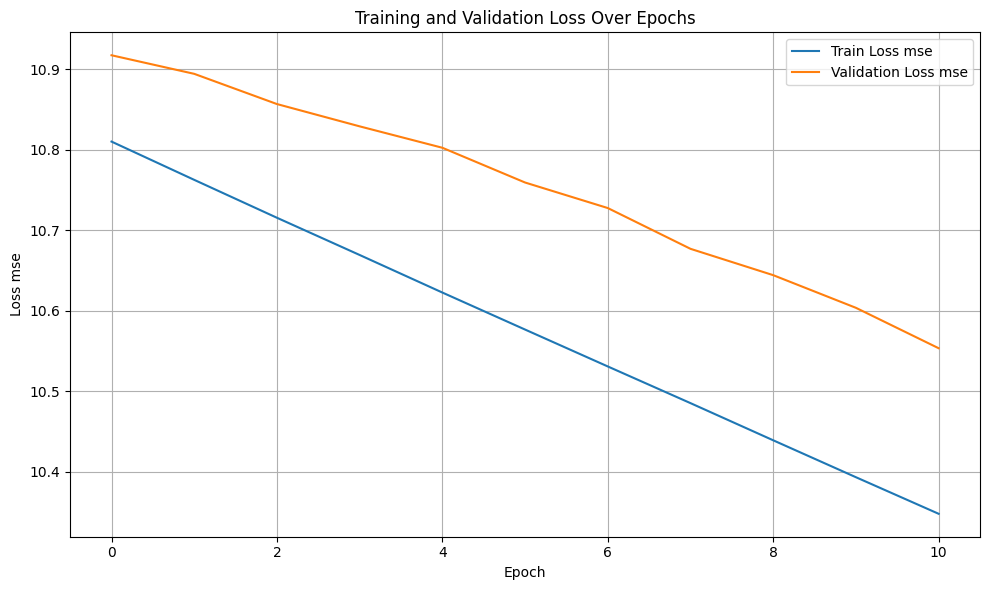

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step

Line 446: Validation RMSE per forecast day: [26.183357 29.414055 35.827824 32.18097  35.021458]
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step

Line 451: Test RMSE per forecast day: [38.199287 37.701897 48.27606  35.616753 46.611122]
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step

Line 455: Train RMSE per forecast day: [ 9.000989   8.9578705  8.635061   8.714129  10.373559 ]

Line 463: Validation MAE per forecast day: [23.552212 26.413326 31.839556 29.134577 31.73748 ]

Line 465: Test MAE per forecast day: [35.476807 34.655415 45.60872  32.177883 43.224007]

Line 467: Train MAE per forecast day: [7.3189826 7.0838776 6.8762746 7.0559006 8.226814 ]

Line 470: Validation MAPE per forecast day: [10.786577 11.99576  14.358188 13.171305 14.310486]

Line 471: Test MAPE per forecast day: [15.762411 15.365078 20.36722  14.228408 19.232145]

Line 472: Train MAPE per forecast day: [4.659382  4.4798465 4.3355846 4.4714093 5.206163 ]

Line 474: Plot Results:


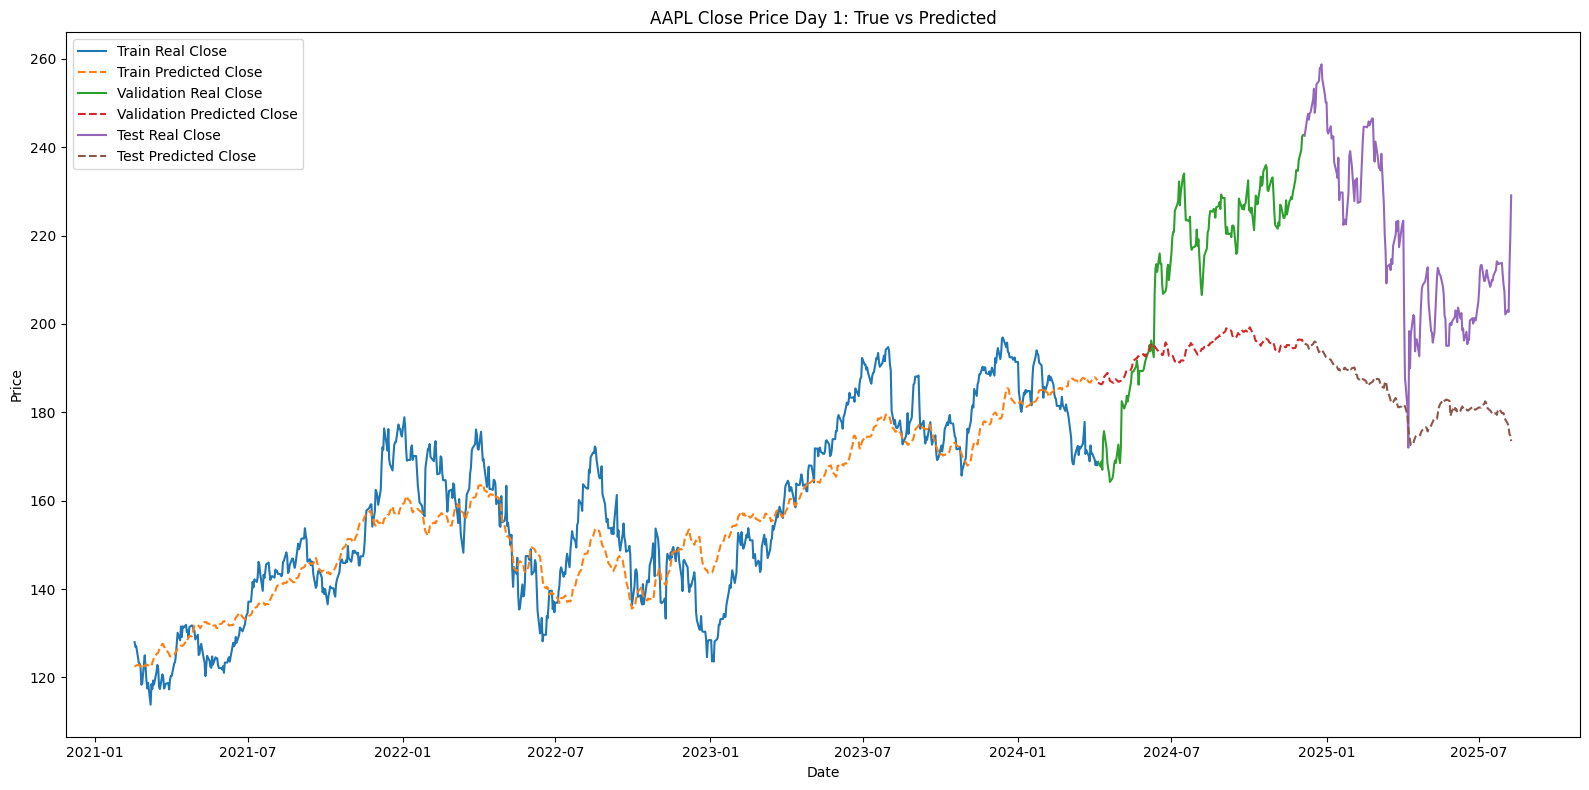


Line 301: Model saved to trainedLSTMModelRev1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

Line 491: Forecast for next 5 days Close price starting from last known Date 2025-08-14 :

Line 501  Day 1 2025-08-15 : 173.5

Line 501  Day 2 2025-08-16 : 176.4

Line 501  Day 3 2025-08-17 : 167.15

Line 501  Day 4 2025-08-18 : 185.99

Line 501  Day 5 2025-08-19 : 169.75

Line 503 === Best Model Summary ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 2530)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 5, 3504)        │    60,030,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 876)            │    15,351,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 876)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        56,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,314,017 (863.32 MB)

 Trainable params: 75,438,005 (287.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 150,876,012 (575.55 MB)


Line 505: === Best Hyperparameters ===

Line 506: LSTM units: 1752

Line 507: Dropout rate: 0.15

Line 508: Learning rate: 2e-06

Line 509: L2 regularization: 0.001

Line 576: run time: 5301.06 sec.


In [38]:
# =========================================================
# DRIVER CODE
# =========================================================
start0 = time.time()

#baseDir = "/mnt/c/Users/LRT/LRTData/MCS/ColoradoBoulder/CUMSDS/Core"

#srcDir = os.path.join(baseDir, "DTSA5509MLIntro/week7/finalProject/data")
#destDir = os.path.join(os.getcwd(), "data")

print("\nLine 361: Make data dictionary=\nEach stock a key in the dictionary.")
stockDataDict = loadAllStocksData()

print("\nLine 364: alignedData, commonDates=\nAll stocks on the same dates series.")
alignedData, commonDates = alignStocksOnCommonDate(stockDataDict)
global numStocks, featuresPerStock
numStocks = len(alignedData)
featuresPerStock = next(iter(alignedData.values())).shape[1]

print("\nLine 370: Create datasets=")
X, y = createDataset(alignedData, commonDates)
print("\nLine 372: X shape", X.shape)
print("\nLine 373: y shape", y.shape)

numSamples = X.shape[0]
trainEnd = int(numSamples * trainRatio)
valEnd = int(numSamples * (trainRatio + valRatio))

XTrain, yTrain = X[:trainEnd], y[:trainEnd]
XVal, yVal = X[trainEnd:valEnd], y[trainEnd:valEnd]
XTest, yTest = X[valEnd:], y[valEnd:]

XTrainScaled, XValTestScaled, xScaler = scaleData(XTrain, np.vstack((XVal, XTest)))
XValScaled, XTestScaled = XValTestScaled[:len(XVal)], XValTestScaled[len(XVal):]

yTrainScaled, yValTestScaled, yScaler = scaleTargets(yTrain, np.vstack((yVal, yTest)))
yValScaled, yTestScaled = yValTestScaled[:len(yVal)], yValTestScaled[len(yVal):]


print("\nLine 389: Setup tuner for hyperparameter tuning")
tuner = kt.RandomSearch(
        buildLstmModel,
        objective=bestObjective, #'val_root_mean_squared_error',
        max_trials=maxTunerTrials,
        executions_per_trial=1,
        directory='tuner_dir',
        project_name='sp500_lstm',
        overwrite=True)

earlyStop = EarlyStopping(monitor=bestMonitor, #'val_root_mean_squared_error',
                          patience=earlyStopPatience,
                          restore_best_weights=True,
                          mode='min')

print("\nLine 404: Search for best hyperparameters")
tuner.search(
        XTrainScaled,
        yTrainScaled,
        validation_data=(XValScaled, yValScaled),
        epochs=epochMax,
        batch_size=bsMax,
        callbacks=[earlyStop],
        verbose=2)

print("\nLine 414: Get best model")
bestModel = tuner.get_best_models(num_models=1)[0]

print("\nLine 417: Fine-tune best model and get training history")
history = bestModel.fit(
        XTrainScaled,
        yTrainScaled,
        validation_data=(XValScaled, yValScaled),
        epochs=epochMax,
        batch_size=bsMax,
        callbacks=[earlyStop],
        verbose=2)

hist = history.history

# Plot and save training loss
plt.figure(figsize=(10, 6))
plt.plot(hist['loss'], label= "Train Loss "+bestLoss )
plt.plot(hist['val_loss'], label="Validation Loss " + bestLoss)
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel("Loss "+bestLoss)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(targetStock + "LossVsEpochsRev1.png")
plt.show()

# Evaluate sets and print errors
# RMSE:
valPredScaled = bestModel.predict(XValScaled)
valPred = yScaler.inverse_transform(valPredScaled)
valRmsePerDay = np.sqrt(np.mean((valPred - yVal) ** 2, axis=0))
print("\nLine 446: Validation RMSE per forecast day:", valRmsePerDay)

testPredScaled = bestModel.predict(XTestScaled)
testPred = yScaler.inverse_transform(testPredScaled)
testRmsePerDay = np.sqrt(np.mean((testPred - yTest) ** 2, axis=0))
print("\nLine 451: Test RMSE per forecast day:", testRmsePerDay)

trainPredScaled = bestModel.predict(XTrainScaled)
trainPred = yScaler.inverse_transform(trainPredScaled)
trainRmsePerDay = np.sqrt(np.mean((trainPred - yTrain) ** 2, axis=0))
print("\nLine 455: Train RMSE per forecast day:", trainRmsePerDay)

#MAE:
valMAEPerDay = np.mean(np.abs(valPred - yVal), axis=0)
print("\nLine 463: Validation MAE per forecast day:", valMAEPerDay)
testMAEPerDay = np.mean(np.abs(testPred - yTest), axis=0)
print("\nLine 465: Test MAE per forecast day:", testMAEPerDay)
trainMAEPerDay = np.mean(np.abs(trainPred - yTrain), axis=0)
print("\nLine 467: Train MAE per forecast day:", trainMAEPerDay)

#MAPE:
valMAPEPerDay = np.mean(np.abs((valPred - yVal) / (yVal + 1e-8)) * 100, axis=0)
testMAPEPerDay = np.mean(np.abs((testPred - yTest) / (yTest + 1e-8)) * 100, axis=0)
trainMAPEPerDay = np.mean(np.abs((trainPred - yTrain) / (yTrain + 1e-8)) * 100, axis=0)
print("\nLine 470: Validation MAPE per forecast day:", valMAPEPerDay)
print("\nLine 471: Test MAPE per forecast day:", testMAPEPerDay)
print("\nLine 472: Train MAPE per forecast day:", trainMAPEPerDay)

print("\nLine 474: Plot Results:")
plotResults(
    commonDates[
        sequenceLength : sequenceLength + len(yTrain) + len(yVal) + len(yTest)],
    yTrain, trainPred, yVal, valPred, yTest, testPred)

# Save best model
saveModel(bestModel)

# Forecast next 5 days from last test sequence
lastSequence = XTest[-1:]
lastSequenceScaled = xScaler.transform(
    lastSequence.reshape(-1, lastSequence.shape[2])).reshape(lastSequence.shape)
forecastScaled = bestModel.predict(lastSequenceScaled)
forecast = yScaler.inverse_transform(forecastScaled).flatten()

print( "\nLine 491: Forecast for next", forecastHorizon, "days Close price starting from last known Date", commonDates[-1].date(), ":",)
for day in range(forecastHorizon):
    forecastDate = (commonDates[-1] + pd.Timedelta(days=day + 1)).strftime("%Y-%m-%d")
    print("\nLine 501  Day", day + 1, forecastDate, ":", round(forecast[day], 2))

print("\nLine 503 === Best Model Summary ===")
bestModel.summary()

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nLine 505: === Best Hyperparameters ===")
print("\nLine 506: LSTM units:", best_hp.get("lstmUnits"))
print("\nLine 507: Dropout rate:", round(best_hp.get("dropoutRate"), 4))
print("\nLine 508: Learning rate:", round(best_hp.get("learningRate"), 6))
print("\nLine 509: L2 regularization:", round(best_hp.get("l2Reg"), 6))


end0 = time.time()
print("\nLine 576: run time:", round((end0 - start0), 2), "sec.")







<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Summary, Conclussions, and Future Work: </h3>

The model works well and is able to forecast stock prices 5 sessions forward. The model is set to forecast AAPL, but it can forecast any other stock as well. The forecast is not very accurate, and this may be corrected by adjusting the tuning range of the hyperparameters, specifically drop out rate, learning rate, epochs, and number of trials in future iterations. The presentation of this project (.pdf) reports the results of longer training.

The results reported are outputs of relatively short and shallow training. It takes hours to get through a more complete training cycle in my CPU. It takes several days to complete multiple trials, partly because the RAM resources (now 16Gb in my system) are stretched beyond 80%, and frequently crash. I have ordered new larger memory sticks to upgrade my RAM to double, and I am expecting to receive them next week.

The errors (RMSE) versus epochs chart shows that the validation error is stable but in a downward trend, suggesting that longer training time may reduce it further.

The 5-day forecast obtained:

Line 491: Forecast for next 5 days Close price starting from last known Date 2025-08-14 :

Line 501  Day 1 2025-08-15 : 173.5

Line 501  Day 2 2025-08-16 : 176.4

Line 501  Day 3 2025-08-17 : 167.15

Line 501  Day 4 2025-08-18 : 185.99

Line 501  Day 5 2025-08-19 : 169.75

Day x represents the first trading session following the one on 2025-08-14. The date itself may not necessarily coincide with the one listed next to Day x.

Line 505: === Best Hyperparameters ===

Line 506: LSTM units: 1752

Line 507: Dropout rate: 0.15

Line 508: Learning rate: 2e-06

Line 509: L2 regularization: 0.001

Line 469: === Errors ===
Line 455: Train RMSE per forecast day: [ 9.000989   8.9578705  8.635061   8.714129  10.373559 ]

Line 463: Validation MAE per forecast day: [23.552212 26.413326 31.839556 29.134577 31.73748 ]

Line 465: Test MAE per forecast day: [35.476807 34.655415 45.60872  32.177883 43.224007]

Line 467: Train MAE per forecast day: [7.3189826 7.0838776 6.8762746 7.0559006 8.226814 ]

Line 470: Validation MAPE per forecast day: [10.786577 11.99576  14.358188 13.171305 14.310486]

Line 471: Test MAPE per forecast day: [15.762411 15.365078 20.36722  14.228408 19.232145]

Line 472: Train MAPE per forecast day: [4.659382  4.4798465 4.3355846 4.4714093 5.206163 ]

Taking the MAPE test error as an estimate of the error of forecast, we can see that there is plenty of room for the model to improve.


Future Developments: More data may improve the model. SP500 has about 10% of the roughly 6000 securities listed in the US, and still that’s small fraction of all securities listed worldwide.

Future extensions of this work would include a wider list of US securities, followed by those listed in international markets added progressively.

Training and hyperparameter tuning with GPU (instead of a CPU, as I used in this case) would allow to train better: either faster with same epochs, or deeper with more epochs, most likely leading to lower validation errors.






<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> References: </h3>

https://keras.io/api/layers/recurrent_layers/lstm/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional // https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

https://keras.io/api/layers/recurrent_layers/bidirectional/

https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

https://www.tensorflow.org/tutorials/keras/keras_tuner

https://keras.io/keras_tuner/

https://keras.io/keras_tuner/getting_started/

https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2

https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf

https://www.geeksforgeeks.org/deep-learning/tf-keras-layers-lstm-in-tensorflow/

github1: https://github.com/colincunningham-cu/dtsa_5511_final_project/blob/main/final_project.ipynb

github2: https://github.com/freddiev4/financial-ts-prediction-with-deeplearning

github3: https://github.com/elayden/Deep-Learning-Framework-for-Financial-Time-Series-Prediction-in-Python-Keras